In [5]:
import pandas as pd

import importlib

import file_loader
importlib.reload(file_loader)

from file_loader import FileLoader

# Percorso del file CSV (usa path relativo)
csv_path = "../data/input/determinazioni_amianto_2024.csv"
# Leggi il CSV con pandas
try:
    # encoding='latin1'  → Vecchi file Windows/Europa occidentale
    # encoding='cp1252'  → Variante Windows, gestisce più simboli (€ ecc.)
    # encoding='utf-8-sig' → Da usare se la prima colonna ha caratteri strani (BOM UTF-8), tipico da Excel
    # Provare diversi encoding se si vedono caratteri strani nei dati/colonne!
    loader = FileLoader(csv_path,';','utf-8-sig')
    df = loader.load()
    print("Dati caricati correttamente:")
    print(df.head())
    print("Record iniziali:", len(df))
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    raise



Dati caricati correttamente:
   codice_record  id_punto_campionamento  \
0            265                     200   
1            282                     201   
2            283                     202   
3            408                     203   
4            409                     204   

                                          nome_punto               Comune  \
0  punto1 - cono di deiezione nei pressi del matt...  SAN SEVERINO LUCANO   
1  punto 2 - piazzola di sosta sottostante un pic...  SAN SEVERINO LUCANO   
2            punto 3 - strada sterrata per 3 confini  SAN SEVERINO LUCANO   
3            loc. Rondinelle - complanare nord MT-BA               MATERA   
4            loc. Rondinelle - complanare nord MT-BA               MATERA   

   id_campionamento                               descrizione_campione  \
0               580         cono di deiezione nei pressi del mattatoio   
1               581  piazzola di sosta sottostante un piccolo front...   
2               582  

In [6]:
import importlib

import amianto_cleaner
importlib.reload(amianto_cleaner)

from amianto_cleaner import AmiantoCleaner

cleaner = AmiantoCleaner(df)
df_clean = cleaner.get_cleaned()
print(df_clean.head())
print("Record dopo cleaning:", len(df_clean))

   codice_record  id_punto_campionamento  \
0            265                     200   
1            282                     201   
2            283                     202   
3            408                     203   
4            409                     204   

                                          nome_punto               comune  \
0  punto1 - cono di deiezione nei pressi del matt...  san severino lucano   
1  punto 2 - piazzola di sosta sottostante un pic...  san severino lucano   
2            punto 3 - strada sterrata per 3 confini  san severino lucano   
3            loc. Rondinelle - complanare nord MT-BA               matera   
4            loc. Rondinelle - complanare nord MT-BA               matera   

   id_campionamento                               descrizione_campione  \
0               580         cono di deiezione nei pressi del mattatoio   
1               581  piazzola di sosta sottostante un piccolo front...   
2               582                       material

In [7]:
import sqlite3

# Crea o apre il file database
conn = sqlite3.connect("../data/db/report.db")  # crea il file se non esiste

# 1. Tabella punti_campionamento
punti_campionamento = df_clean[['id_punto_campionamento', 'nome_punto', 'comune']].drop_duplicates()
# Salva il DataFrame in una tabella chiamata
punti_campionamento.to_sql("punti_campionamento", conn, if_exists="replace", index=False)

# 2. Tabella campionamenti
campionamenti = df_clean[['id_campionamento', 'id_punto_campionamento', 'descrizione_campione', 'tipo_attivita', 'data_campionamento', 'impianto', 'campagna', 'matrice_indagata']].drop_duplicates()
# Salva il DataFrame in una tabella chiamata
campionamenti.to_sql("campionamenti", conn, if_exists="replace", index=False)

# 3. Tabella esiti_campionamento
esiti_campionamento = df_clean[['id_esito', 'id_campionamento', 'presenza_di_fibre', 'lfi', 'lfs', 'concentrazione', 'sensibilita_misura',
                                'tecnica', 'metodica', 'limite_normativo', 'valore_riferimento_non_normativo', 'norma', 'fonte',
                                'um', 'esito_normativo', 'esito_sul_valore_riferimento', 'pacchetto_analisi', 'tipo_amianto_rilevato']]
# Salva il DataFrame in una tabella chiamata
esiti_campionamento.to_sql("esiti_campionamento", conn, if_exists="replace", index=False)

# Salva il DataFrame in una tabella chiamata
# df_clean.to_sql("amianto", conn, if_exists="replace", index=False)

resultPuntiCampionamento = conn.execute("SELECT COUNT(*) FROM punti_campionamento").fetchone()
resultCampionamenti = conn.execute("SELECT COUNT(*) FROM campionamenti").fetchone()
resultEsitiCampionamento = conn.execute("SELECT COUNT(*) FROM esiti_campionamento").fetchone()

print("Totale record from punti_campionamento in SQLite:", resultPuntiCampionamento[0])
print("Totale record from campionamenti in SQLite:", resultPuntiCampionamento[0])
print("Totale record from esiti_campionamento in SQLite:", resultPuntiCampionamento[0])

conn.close()


Totale record from punti_campionamento in SQLite: 26
Totale record from campionamenti in SQLite: 26
Totale record from esiti_campionamento in SQLite: 26


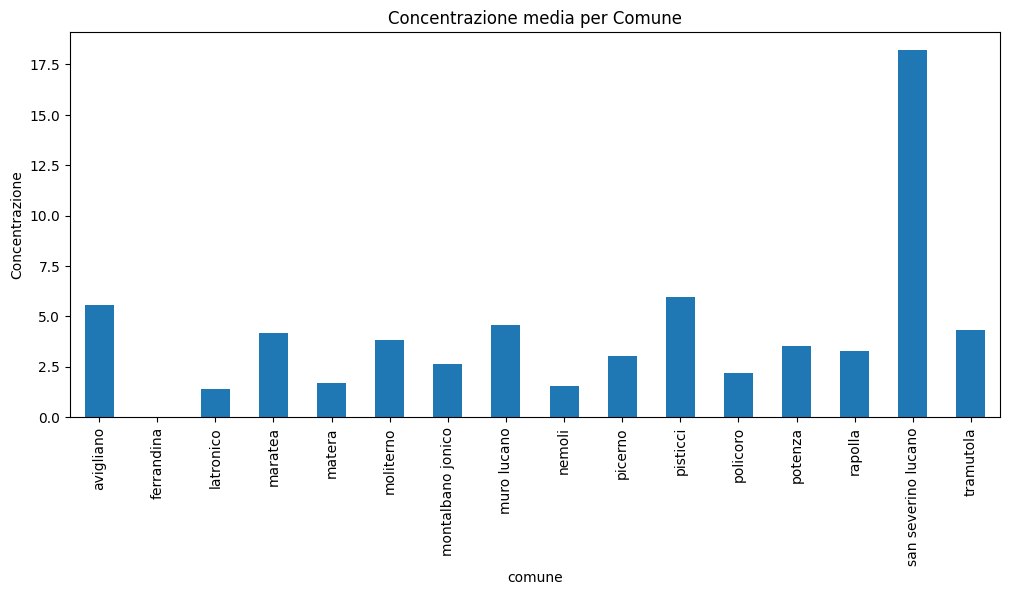

In [ ]:
import matplotlib.pyplot as plt

conn = sqlite3.connect("../data/db/report.db")

query = """
SELECT 
    pc.comune, 
    ec.concentrazione
FROM 
    punti_campionamento pc
JOIN 
    campionamenti c ON pc.id_punto_campionamento = c.id_punto_campionamento
JOIN 
    esiti_campionamento ec ON c.id_campionamento = ec.id_campionamento
"""

df = pd.read_sql_query(query, conn)

df['concentrazione'] = pd.to_numeric(df['concentrazione'], errors='coerce')
df.groupby('comune')['concentrazione'].mean().plot(kind='bar', figsize=(12,5))
plt.title('Concentrazione media per Comune')
plt.ylabel('Concentrazione')
plt.show()

conn.close()

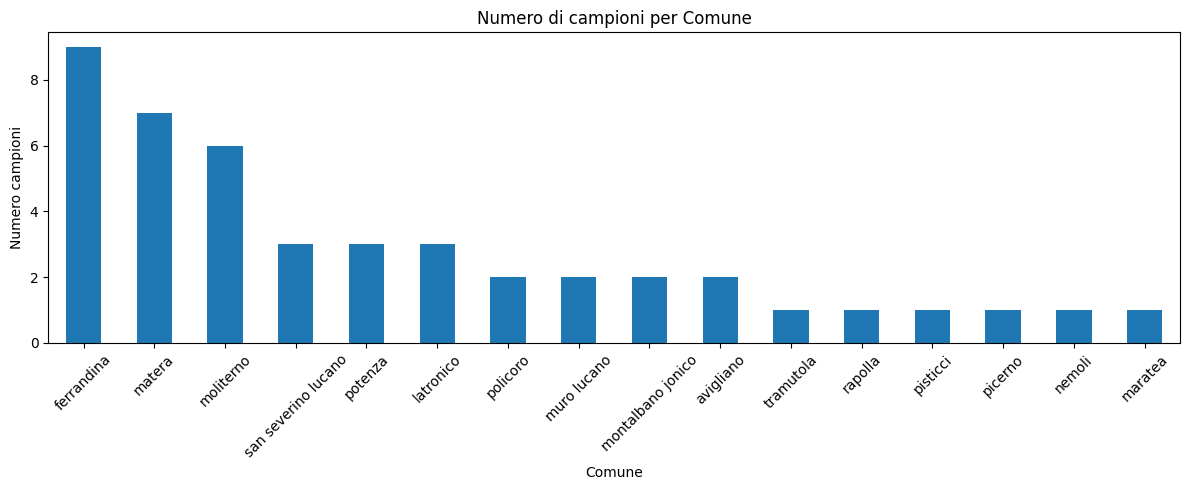

In [10]:
conn = sqlite3.connect("../data/db/report.db")

query = """
SELECT 
    pc.comune, 
    COUNT(*) as numero_campioni
FROM 
    punti_campionamento pc
JOIN 
    campionamenti c ON pc.id_punto_campionamento = c.id_punto_campionamento
GROUP BY 
    pc.comune
ORDER BY 
    numero_campioni DESC
"""
df_comuni = pd.read_sql_query(query, conn)

df_comuni.set_index('comune')['numero_campioni'].plot(kind='bar', figsize=(12,5))
plt.title("Numero di campioni per Comune")
plt.xlabel("Comune")
plt.ylabel("Numero campioni")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

conn.close()


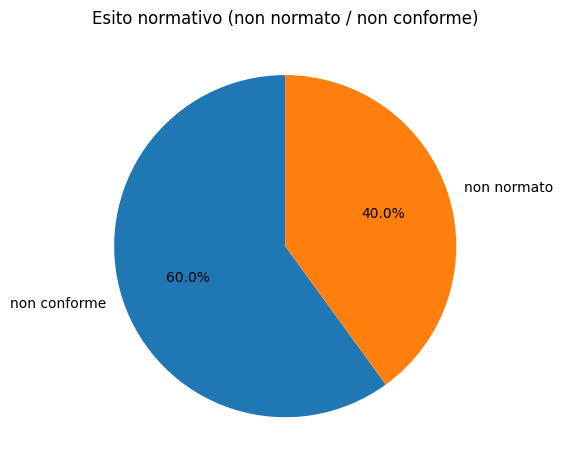

In [12]:
conn = sqlite3.connect("../data/db/report.db")

query = """
SELECT 
    esito_normativo, 
    COUNT(*) as count
FROM 
    esiti_campionamento
GROUP BY 
    esito_normativo
"""
df_esiti = pd.read_sql_query(query, conn)

df_esiti.set_index('esito_normativo')['count'].plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Esito normativo (non normato / non conforme)")
plt.ylabel('')  # Rimuove l'etichetta Y
plt.tight_layout()
plt.show()

conn.close()

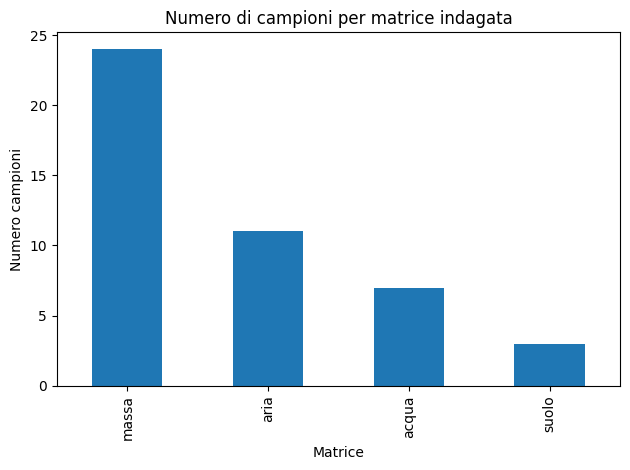

In [13]:
conn = sqlite3.connect("../data/db/report.db")

query = """
SELECT 
    matrice_indagata, 
    COUNT(*) as numero_campioni
FROM 
    campionamenti
GROUP BY 
    matrice_indagata
ORDER BY 
    numero_campioni DESC
"""
df_matrici = pd.read_sql_query(query, conn)

df_matrici.set_index('matrice_indagata')['numero_campioni'].plot(kind='bar')
plt.title("Numero di campioni per matrice indagata")
plt.xlabel("Matrice")
plt.ylabel("Numero campioni")
plt.tight_layout()
plt.show()

conn.close()

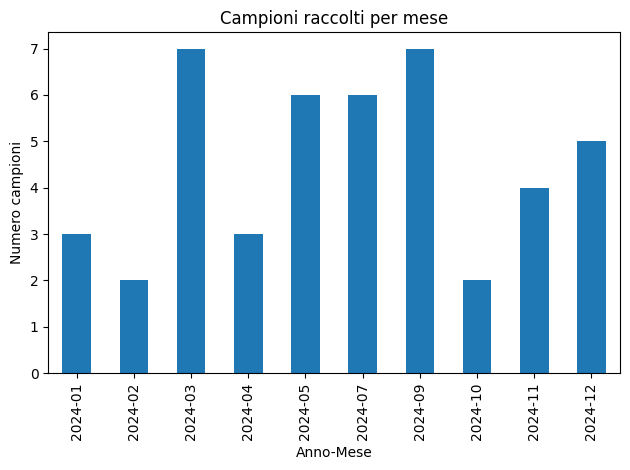

In [14]:
conn = sqlite3.connect("../data/db/report.db")

query = """
SELECT 
    data_campionamento
FROM 
    campionamenti
WHERE
    data_campionamento IS NOT NULL
"""
df_date = pd.read_sql_query(query, conn)

df_date['data_campionamento'] = pd.to_datetime(df_date['data_campionamento'], errors='coerce')

# Crea la colonna anno-mese
df_date['anno_mese'] = df_date['data_campionamento'].dt.to_period('M')

# Conta i campioni per mese
df_date.groupby('anno_mese').size().plot(kind='bar')
plt.title("Campioni raccolti per mese")
plt.xlabel("Anno-Mese")
plt.ylabel("Numero campioni")
plt.tight_layout()
plt.show()
